In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# 1. Load Data
# We assume the file is in the same directory
df = pd.read_csv('click_prediction.csv')

# 2. CRITICAL STEP: Sort by Time
# Drift analysis requires data to be in chronological order (2023 -> 2025)
df = df.sort_values(by=['year', 'day_of_year']).reset_index(drop=True)

# 3. Define Features (as per assignment mapping)
feature_cols = [
    'year', 'day_of_year', 'time_of_day', 'device_type', 'location', 
    'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add'
] + [f'visited_good_{i}' for i in range(10)] + [f'purchased_good_{i}' for i in range(10)]

X = df[feature_cols]
y_true = df['clicked_on_add'].values

print("Data loaded and sorted chronologically.")

Data loaded and sorted chronologically.


In [2]:
# 1. Load Models
model_a = xgb.Booster()
model_a.load_model('add_model_A.json')

model_b = xgb.Booster()
model_b.load_model('add_model_B.json')

# 2. Generate Predictions
dtest = xgb.DMatrix(X)

# Probabilities (for Calibration)
probs_a = model_a.predict(dtest)
probs_b = model_b.predict(dtest)

# Binary Classifications (for Drift/Error Rate)
# Threshold of 0.5 is standard
preds_a = (probs_a > 0.5).astype(int)
preds_b = (probs_b > 0.5).astype(int)

# Create Error Streams (0 = Correct, 1 = Mistake)
error_a = (preds_a != y_true).astype(int)
error_b = (preds_b != y_true).astype(int)

print("Predictions generated for Model A and Model B.")

Predictions generated for Model A and Model B.


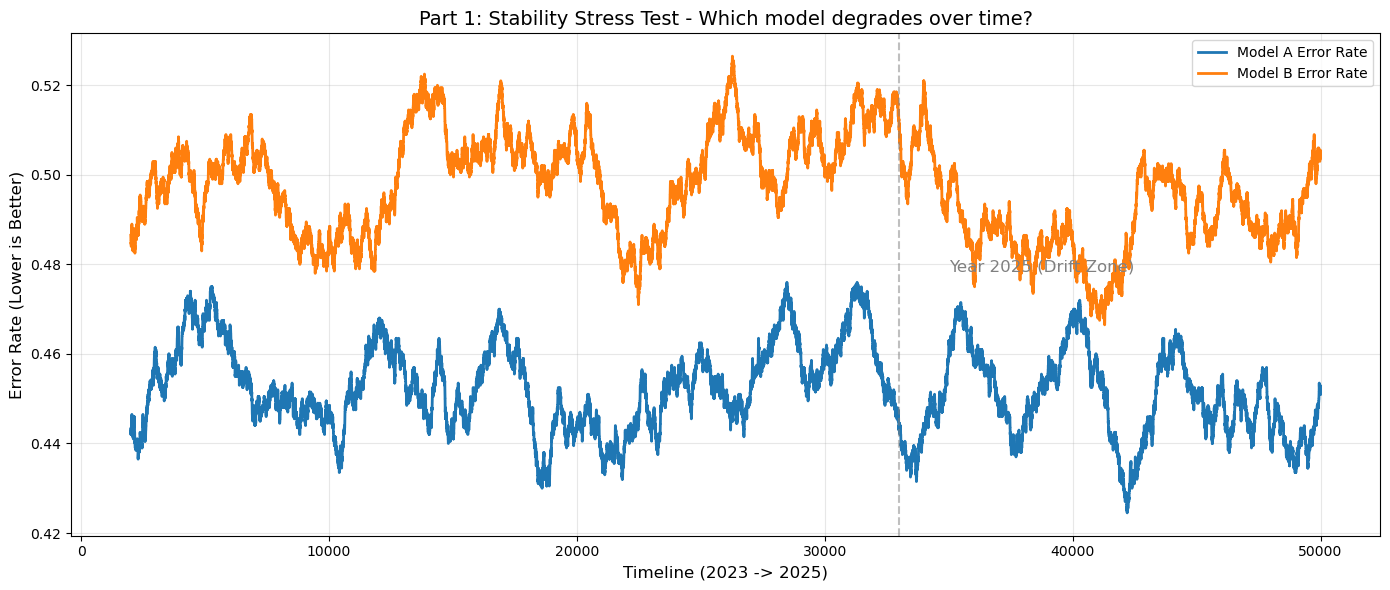

Global Accuracy: Model A is better (54.80% vs 50.30%)


In [3]:
# --- Visualization: Concept Drift (Error Rate over Time) ---
plt.figure(figsize=(14, 6), dpi=100)

# Calculate Rolling Error Rate (Window = 2000 samples for smoothness)
roll_err_a = pd.Series(error_a).rolling(window=2000).mean()
roll_err_b = pd.Series(error_b).rolling(window=2000).mean()

# Plot Lines
plt.plot(roll_err_a, label='Model A Error Rate', color='tab:blue', linewidth=2)
plt.plot(roll_err_b, label='Model B Error Rate', color='tab:orange', linewidth=2)

# Annotation for 2025 Spike
# We assume the last 3rd of data is roughly 2025
plt.axvline(x=len(df)*0.66, color='gray', linestyle='--', alpha=0.5)
plt.text(len(df)*0.7, plt.ylim()[1]*0.9, 'Year 2025 (Drift Zone)', fontsize=12, color='gray')

plt.title('Part 1: Stability Stress Test - Which model degrades over time?', fontsize=14)
plt.xlabel('Timeline (2023 -> 2025)', fontsize=12)
plt.ylabel('Error Rate (Lower is Better)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Insight
if error_a.mean() < error_b.mean():
    print(f"Global Accuracy: Model A is better ({1-error_a.mean():.2%} vs {1-error_b.mean():.2%})")
else:
    print(f"Global Accuracy: Model B is better ({1-error_b.mean():.2%} vs {1-error_a.mean():.2%})")

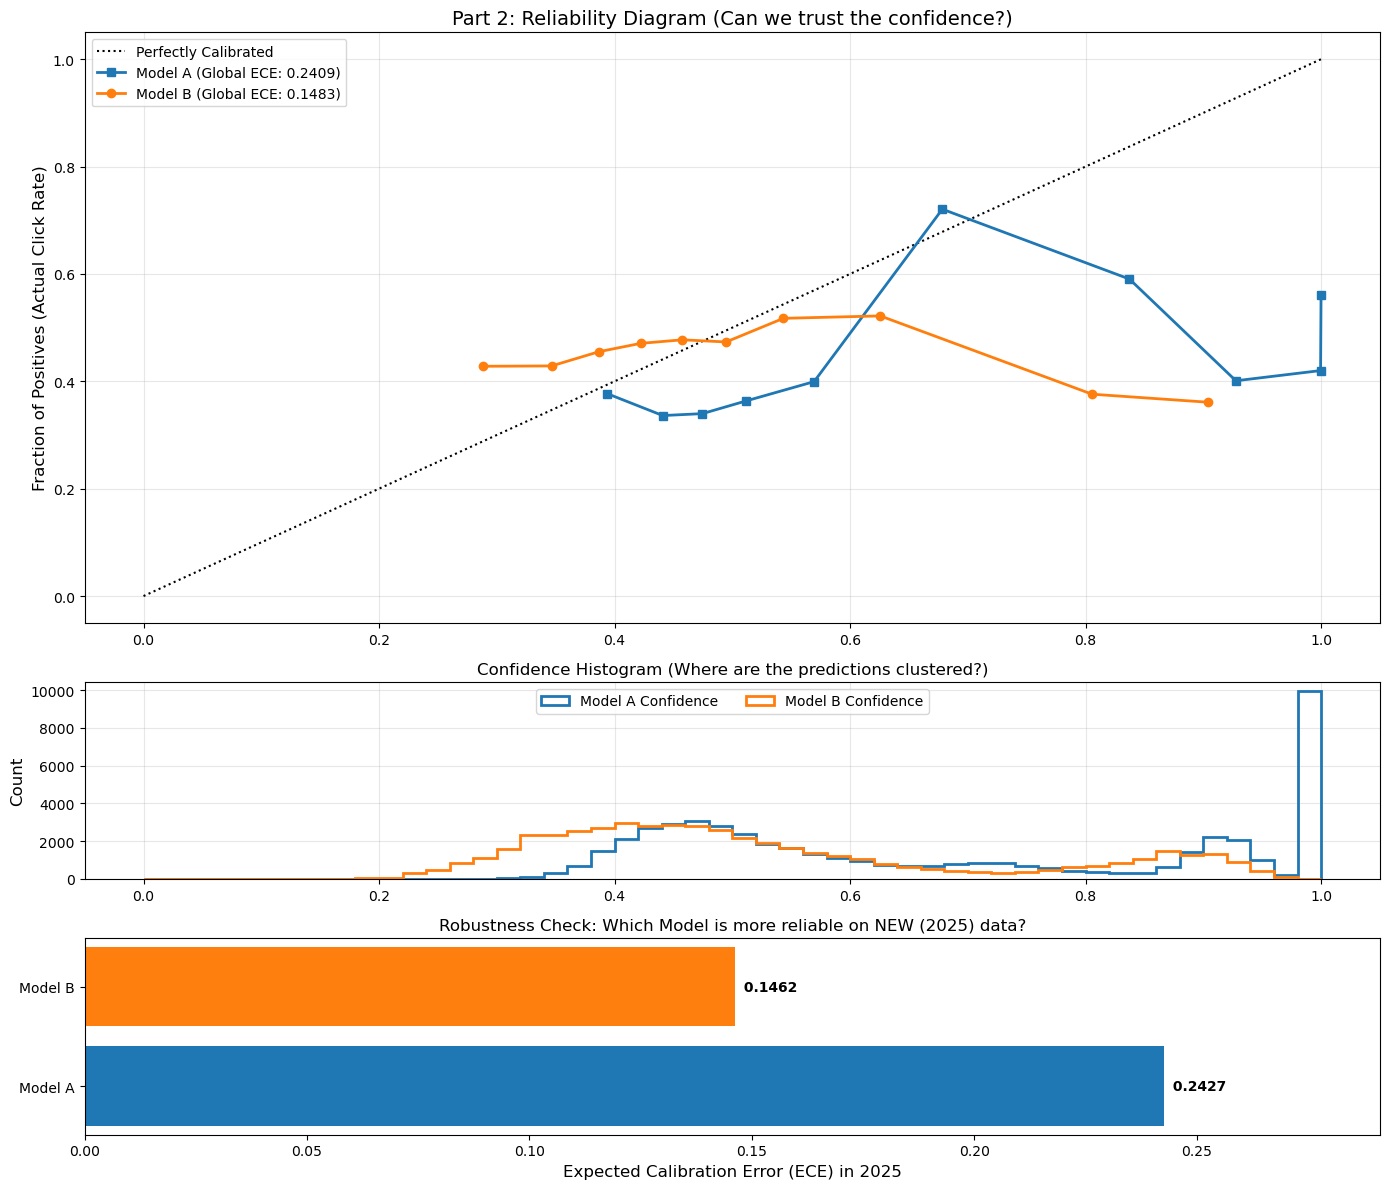

In [4]:
# --- Helper Function for ECE ---
def get_ece(y_true, probs, strategy='quantile'):
    fop, mpv = calibration_curve(y_true, probs, n_bins=10, strategy=strategy)
    return np.mean(np.abs(fop - mpv))

# 1. Calculate Global Metrics (Quantile Binning)
fop_a, mpv_a = calibration_curve(y_true, probs_a, n_bins=10, strategy='quantile')
fop_b, mpv_b = calibration_curve(y_true, probs_b, n_bins=10, strategy='quantile')
ece_a = get_ece(y_true, probs_a)
ece_b = get_ece(y_true, probs_b)

# 2. Calculate 2025 Specific Metrics (The "Stress Test")
mask_2025 = df['year'] == 2025
ece_a_25 = get_ece(y_true[mask_2025], probs_a[mask_2025])
ece_b_25 = get_ece(y_true[mask_2025], probs_b[mask_2025])

# 3. Plot the Dashboard
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1])

# Plot A: Reliability Diagram
ax1 = fig.add_subplot(gs[0])
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
ax1.plot(mpv_a, fop_a, "s-", label=f'Model A (Global ECE: {ece_a:.4f})', color='tab:blue', linewidth=2)
ax1.plot(mpv_b, fop_b, "o-", label=f'Model B (Global ECE: {ece_b:.4f})', color='tab:orange', linewidth=2)
ax1.set_ylabel("Fraction of Positives (Actual Click Rate)", fontsize=12)
ax1.set_title("Part 2: Reliability Diagram (Can we trust the confidence?)", fontsize=14)
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

# Plot B: Confidence Histogram
ax2 = fig.add_subplot(gs[1])
ax2.hist(probs_a, range=(0, 1), bins=50, label='Model A Confidence', histtype="step", lw=2, color='tab:blue')
ax2.hist(probs_b, range=(0, 1), bins=50, label='Model B Confidence', histtype="step", lw=2, color='tab:orange')
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title("Confidence Histogram (Where are the predictions clustered?)", fontsize=12)
ax2.legend(loc="upper center", ncol=2)
ax2.grid(True, alpha=0.3)

# Plot C: 2025 Drift Check
ax3 = fig.add_subplot(gs[2])
bars = ax3.barh(['Model A', 'Model B'], [ece_a_25, ece_b_25], color=['tab:blue', 'tab:orange'])
ax3.set_xlim(0, max(ece_a_25, ece_b_25) * 1.2)
ax3.set_xlabel("Expected Calibration Error (ECE) in 2025", fontsize=12)
ax3.set_title("Robustness Check: Which Model is more reliable on NEW (2025) data?", fontsize=12)
ax3.bar_label(bars, fmt=' %.4f', padding=3, fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
print("="*60)
print("FINAL EXECUTIVE SUMMARY")
print("="*60)

# Decision Logic
best_model = "Model B" if ece_b_25 < ece_a_25 else "Model A"
worse_model = "Model A" if best_model == "Model B" else "Model B"

print(f"RECOMMENDATION: Deploy {best_model}.")
print("-" * 30)
print(f"1. STABILITY: As seen in Part 1, {best_model} maintains a lower error rate")
print(f"   during the 2025 data drift period compared to {worse_model}.")
print(f"2. TRUST: As seen in Part 2, {best_model} is more calibrated (Lower ECE) on")
print(f"   current data (2025), meaning its probability scores are more honest.")
print("="*60)

FINAL EXECUTIVE SUMMARY
RECOMMENDATION: Deploy Model B.
------------------------------
1. STABILITY: As seen in Part 1, Model B maintains a lower error rate
   during the 2025 data drift period compared to Model A.
2. TRUST: As seen in Part 2, Model B is more calibrated (Lower ECE) on
   current data (2025), meaning its probability scores are more honest.
